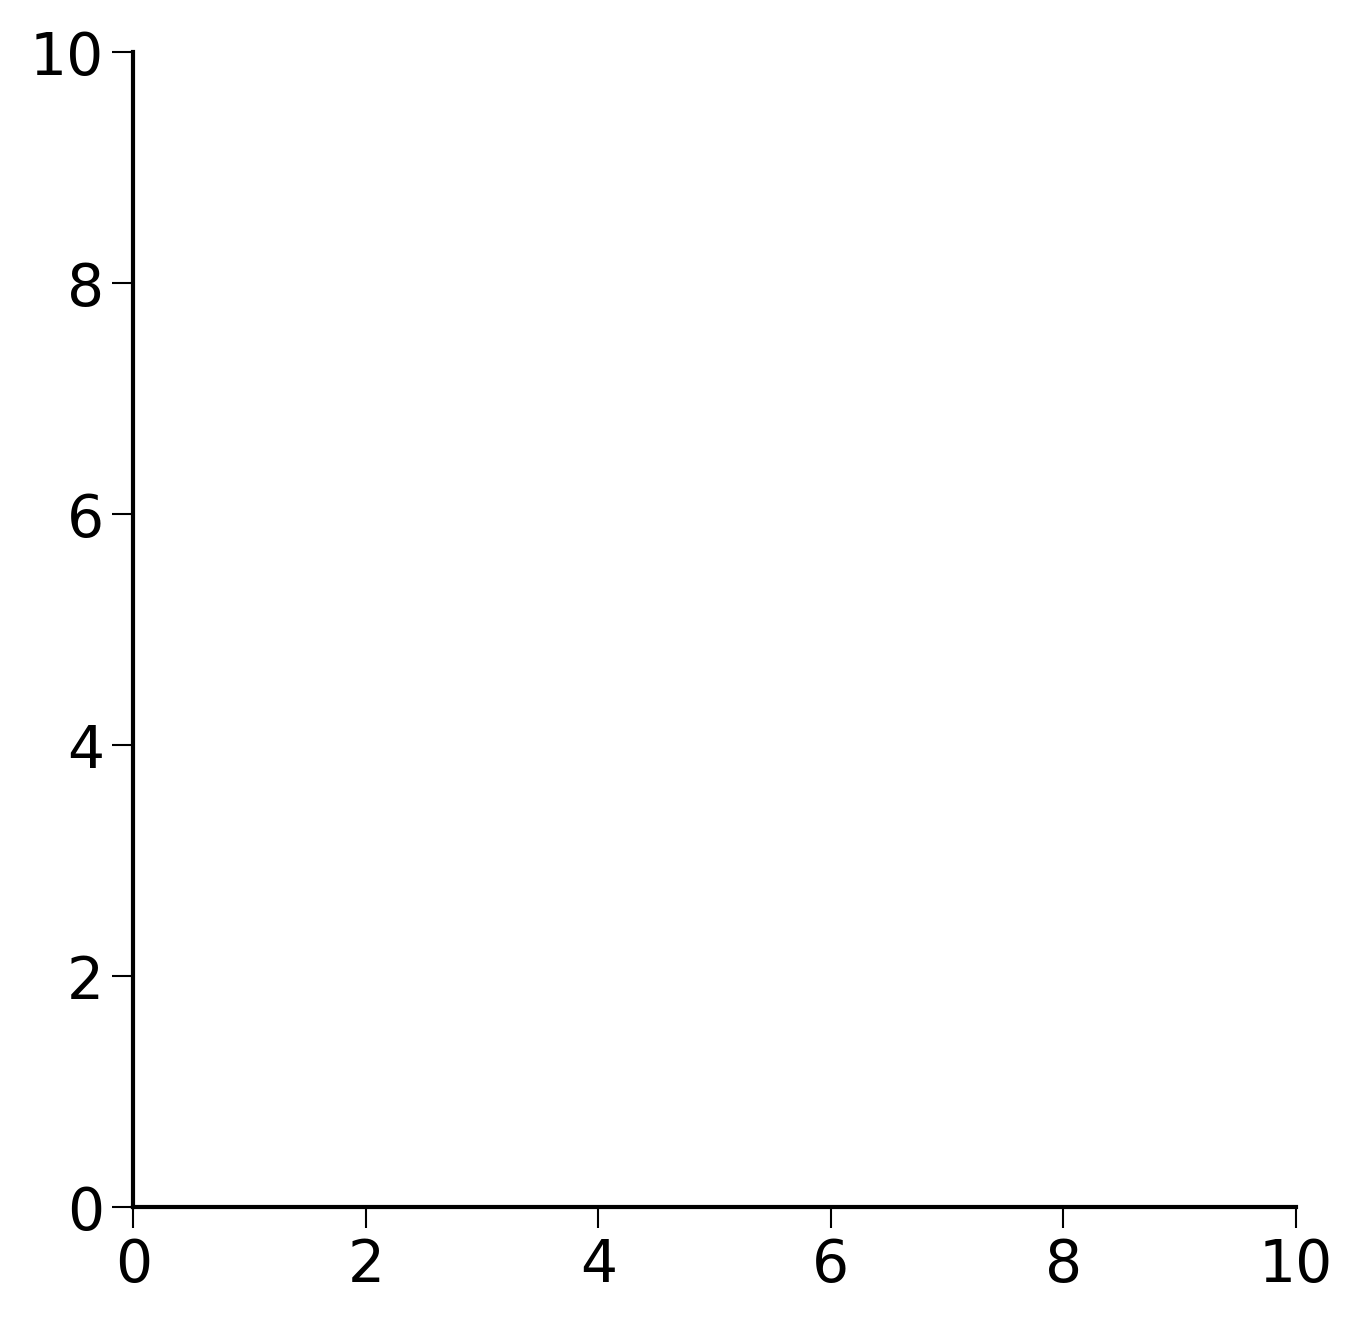

In [513]:
import scanpy as sc
import numpy as np
import operator
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
#setPltLinewidth(0)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,6,7"

from torch.nn import DataParallel
import os
import anndata as ad
import cospar as cs
import scanpy as sc
def createFig(figsize=(8, 4)):
    fig,ax=plt.subplots()           
    ax.spines['right'].set_color('none')     
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')     
    #ax.spines['left'].set_color('none')
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
        line.set_color("#585958")
        line.set_markeredgewidth(0.5)
    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
        line.set_markeredgewidth(0.5)
        line.set_color("#585958")
    ax.set_xbound(0,10)
    ax.set_ybound(0,10)
    fig.set_size_inches(figsize)
    return fig,ax
def setPltLinewidth(linewidth:float):
    mpl.rcParams['axes.linewidth'] = linewidth
import matplotlib as mpl
fig,ax=createFig()
fig.set_size_inches(5,5)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
setPltLinewidth(1)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.family'] = "Arial"
adata = cs.datasets.hematopoiesis_130K()

In [514]:
adata.obs

n_counts Time_Point Source Well  mito_frac time_info  state_info  \
index                                                                         
0       2878.791992        6.0     LK    2   0.059597         6      undiff   
1       2878.841309        6.0     LK    2   0.068863         6      undiff   
2       2878.725098        6.0     LK    2   0.071967         6    Monocyte   
3       2878.786865        6.0     LK    2   0.054356         6  Neutrophil   
4       2878.721924        6.0     LK    2   0.064645         6      undiff   
...             ...        ...    ...  ...        ...       ...         ...   
130882  2878.757812        6.0    LSK    1   0.070476         6      undiff   
130883  2878.762695        6.0    LSK    1   0.046033         6      undiff   
130884  2878.743652        6.0    LSK    1   0.071918         6    Monocyte   
130885  2878.765869        6.0    LSK    1   0.039647         6    Monocyte   
130886  2878.757324        6.0    LSK    1   0.072625         6      undiff   

        precomputed_fate_bias  selected_clonal_cells  Gata1_states  
index                                                               
0                         0.5                   True         False  
1                         0.5                   True          True  
2                         0.5                   True         False  
3                         0.0                  False         False  
4                         0.5                   True          True  
...                       ...                    ...           ...  
130882                    0.0                  False          True  
130883                    0.5                   True          True  
130884                    0.0                  False         False  
130885                    0.0                  False         False  
130886                    0.0                  False          True  

[130887 rows x 10 columns]

In [515]:
adata.obs['index']=0
adata.obs['index']=adata.obs.index.astype(int)
adata.obs['time_info']=adata.obs['time_info'].astype(int)

In [516]:
adata.obs['id']=0
sum=1
for i in adata.obsm['X_clone'].T:
    item1=i.toarray()
    for j in range(len(item1[0])):
        if(item1[0][j]==True):
            adata.obs['id'][j]=sum
    sum+=1
        


/tmp/ipykernel_58143/3574892436.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['id'][j]=sum


In [532]:
adata_ga=cs.datasets.hematopoiesis_Gata1_states()



AnnData object with n_obs × n_vars = 38457 × 25289
    obs: 'n_counts', 'Source', 'Well', 'mito_frac', 'time_info', 'state_info'
    var: 'highly_variable'
    uns: 'AllCellCyc_genes', 'clonal_time_points', 'data_des', 'max_mito', 'min_tot', 'new_highvar_genes', 'state_info_colors', 'time_info_colors', 'time_ordering'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_umap'

In [535]:
adata_ga.obs

n_counts Source Well  mito_frac time_info state_info
index                                                          
1       2878.841309     LK    2   0.068863         6     undiff
4       2878.721924     LK    2   0.064645         6     undiff
9       2878.750488     LK    2   0.041053         6       Baso
18      2878.749023     LK    2   0.034884         6       Baso
20      2878.723389     LK    2   0.050048         6       Mast
...             ...    ...  ...        ...       ...        ...
130878  2878.765381    LSK    1   0.099458         6     undiff
130880  2878.755615    LSK    1   0.065083         6       Baso
130882  2878.757812    LSK    1   0.070476         6     undiff
130883  2878.762695    LSK    1   0.046033         6     undiff
130886  2878.757324    LSK    1   0.072625         6     undiff

[38457 rows x 6 columns]

In [ ]:
adata.write('/home/zhengtuo/songtao/weinreb-test.h5ad')


In [539]:
fatetrue=[]
adata2=adata[(adata.obs['precomputed_fate_bias']!=0.5)]
for i in range((adata2.shape[0])):
    if(adata2.obs['precomputed_fate_bias'][i]>0.5):
        fatetrue.append(1)
    else:
        fatetrue.append(0)

In [540]:
xclone=adata2.obs['id'].unique()#1600个xclone为unidff有groundtruth
adata3=adata[adata.obs['id'].isin(xclone)]
adata3.obs['index']=0
adata3.obs['index']=adata3.obs.index.astype(int)
adata3.obs['id'].unique().shape#1600

/tmp/ipykernel_58143/83777079.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata3.obs['index']=0


(2691,)

In [542]:
df['cell1_type'].unique()

array(['Neutrophil', 'undiff', 'Monocyte', 'Eos', 'Lymphoid', 'Baso',
       'Ccr7_DC', 'Meg', 'Mast'], dtype=object)

/tmp/ipykernel_1645934/3574892436.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['id'][j]=sum


In [541]:
weinreb_agg = adata3.obs.groupby("id").agg({"index":list,'time_info':list,'state_info':list})
weinreb_agg


index  \
id                                                        
0     [3, 5, 7, 9, 10, 11, 12, 17, 19, 20, 21, 22, 2...   
1                [83393, 84420, 124798, 124871, 128164]   
4                                        [84897, 88019]   
5     [62462, 63711, 64803, 113428, 113473, 115781, ...   
9                [908, 1438, 8037, 10550, 21968, 25721]   
...                                                 ...   
5854                       [42512, 54803, 71357, 72461]   
5856                                     [72565, 92425]   
5860                                     [42110, 50486]   
5861                                     [10340, 23601]   
5864                       [72818, 77377, 77521, 97565]   

                                              time_info  \
id                                                        
0     [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...   
1                                       [4, 4, 6, 6, 6]   
4                                                [4, 4]   
5                           [4, 4, 4, 6, 6, 6, 6, 6, 6]   
9                                    [6, 6, 6, 4, 4, 4]   
...                                                 ...   
5854                                       [2, 2, 6, 6]   
5856                                             [6, 4]   
5860                                             [2, 2]   
5861                                             [4, 4]   
5864                                       [6, 6, 6, 4]   

                                             state_info  
id                                                       
0     [Neutrophil, Neutrophil, undiff, Baso, Neutrop...  
1              [undiff, undiff, undiff, undiff, undiff]  
4                                      [undiff, undiff]  
5     [Baso, Baso, Baso, Baso, Baso, Baso, Baso, Bas...  
9     [Baso, Baso, Neutrophil, undiff, undiff, Neutr...  
...                                                 ...  
5854               [undiff, undiff, undiff, Neutrophil]  
5856                                   [undiff, undiff]  
5860                                   [undiff, undiff]  
5861                                     [undiff, Baso]  
5864                   [undiff, undiff, undiff, undiff]  

[2691 rows x 3 columns]

In [193]:
adata.obs[adata.obs['index']==11635]

time_info  state_info  NeuMon_fate_bias  NeuMon_mask  \
11635          6  Neutrophil               0.5        False   

       progenitor_Ccr7_DC  progenitor_Mast  progenitor_Meg  progenitor_pDC  \
11635                   0                0               0               0   

       progenitor_Eos  progenitor_Lymphoid  progenitor_Erythroid  \
11635               0                    0                     0   

       progenitor_Baso  progenitor_Neutrophil  progenitor_Monocyte  \
11635                0                      0                    0   

       sp_500_idx  MLPClassifier_predicted_bias  growth_rate_raw  \
11635       False                           0.0              0.0   

       growth_rate_smooth  id  index  
11635            0.043464   2  11635

In [ ]:
path = '/home/zhengtuo/songtao/weinreb-130k.csv'
for i,indices,reprog,reannotation in zip(weinreb_agg.index, 
          weinreb_agg['index'], 
          weinreb_agg['time_info'],
          weinreb_agg['state_info']):
    tmp_df = adata.obs.iloc[indices]
    for ids,r,from_type in zip(indices,reprog,reannotation):
        for j, to_day, to_type in tmp_df.loc[
            np.array(tmp_df['index'] != ids) & 
            np.array(tmp_df['time_info'] > r),
            ['index','time_info','state_info']
        ].to_numpy():
            df= pd.DataFrame(data=[[ids,from_type,r,j,to_day,to_type,i]])
            if not os.path.exists(path):
                df.to_csv(path, header=['cell1', 'cell1_type','cell1_day','cell2','cell2_day','cell2_type','clone_id'], index=False, mode='a')
            else:
                df.to_csv(path, header=False, index=False, mode='a')
            #print((ids,from_type,r,j,to_day,to_type))
        
        

In [8]:
##试着加入其他类别的day4->day6
import pandas as pd
import random

df = pd.read_csv("/home/zhengtuo/songtao/weinreb.csv")
df=df[(df['cell2_type']!='undiff')&(df['cell2_type']!='Neu_Mon')]
df=df[(df['cell1_type']=='undiff')]
df2 = [df for _, df in df.groupby('clone_id')]
random.shuffle(df2)
len_train=1120#len(a)*0.7 1317
len_test=480#len(a)-len_train 565
cell_day2_all=list(set(list(df['cell1'])))
cell_day46_all=list(set(list(df['cell2'])))


In [9]:
len(df2)

1415

In [399]:
testcell1=[]
testcell2=[]
traincell1=[]
traincell2=[]
#dic={'Baso':0,'Ccr7_DC':1,'Eos':2,'Erythroid':3,'Lymphoid':4,'Mast':5,'Meg':6,'Monocyte':7,'Neutrophil':8,'Undifferentiated':9,'pDC':10}
#dic={'Baso':0,'Ccr7_DC':1,'Eos':2,'Erythroid':3,'Lymphoid':4,'Mast':5,'Meg':6,'Monocyte':7,'Neutrophil':8,'pDC':9}
dic={'Monocyte':0, 'Neutrophil':1, 'Lymphoid':2,'Mast':3, 'Ccr7_DC':4,
       'Baso':5, 'Eos':6,'NeutrophilNeutrophil':7,'MonocyteMonocyte':8,'BasoBaso':9}
train_rel=[]
test_rel=[]
# a=df.groupby('lineage_id')
sum_train=0
for j in df2:
    if(sum_train<len_train):
        cell1_index=j['cell1'].values
        cell2_index=j['cell2'].values
        sum_train+=1
        for count in range(len(cell1_index)):
            if(j['cell1_type'].values[count]=='undiff'):
                #dic_sameBC[cell1_index[count]].append(cell2_index[count])
                #dic_sameBC[cell1_index[count]]=cell2_index
                train_rel.append(dic[j['cell2_type'].values[count]])
                traincell1.append(cell1_index[count])
                traincell2.append(cell2_index[count])
            else:
                item=str(j['cell1_type'].values[count])+str(j['cell2_type'].values[count])
                train_rel.append(dic[item])
                traincell1.append(cell1_index[count])
                traincell2.append(cell2_index[count])
    else:
        cell1_index=j['cell1'].values
        cell2_index=j['cell2'].values
        sum_train+=1
        for count in range(len(cell1_index)):
            if(j['cell1_type'].values[count]=='undiff'):
                #dic_sameBC[cell1_index[count]].append(cell2_index[count])
                #dic_sameBC[cell1_index[count]]=cell2_index
                test_rel.append(dic[j['cell2_type'].values[count]])
                testcell1.append(cell1_index[count])
                testcell2.append(cell2_index[count])
            else:
                item=str(j['cell1_type'].values[count])+str(j['cell2_type'].values[count])
                test_rel.append(dic[item])
                testcell1.append(cell1_index[count])
                testcell2.append(cell2_index[count])
        



In [500]:
df[df['cell1_type']=='Baso']

cell1 cell1_type  cell1_day  cell2  cell2_day  cell2_type  clone_id
7235   22837       Baso          2  23862          6  Neutrophil       583
7236   22837       Baso          2  24651          6  Neutrophil       583
7237   22837       Baso          2  25295          6  Neutrophil       583
7238   22837       Baso          2  28103          6  Neutrophil       583
7239   22837       Baso          2  29549          6  Neutrophil       583
7240   22837       Baso          2  36645          4  Neutrophil       583
7241   22837       Baso          2  36713          4      undiff       583
12939  33540       Baso          4  26411          6  Neutrophil      1369
12940  33540       Baso          4  29228          6  Neutrophil      1369
12941  33540       Baso          4  31830          6  Neutrophil      1369
12945  35782       Baso          4  26411          6  Neutrophil      1369
12946  35782       Baso          4  29228          6  Neutrophil      1369
12947  35782       Baso          4  31830          6  Neutrophil      1369
14637  34886       Baso          4  48490          6  Neutrophil      1521
15456  17349       Baso          2  22345          4  Neutrophil      1621
15457  17349       Baso          2  27888          6        Baso      1621
15458  17349       Baso          2  32004          6        Baso      1621
26360  33689       Baso          4  42796          6  Neutrophil      2636
26361  33689       Baso          4  43610          6  Neutrophil      2636
26362  33689       Baso          4  44617          6  Neutrophil      2636
26363  33689       Baso          4  45355          6  Neutrophil      2636
26364  33689       Baso          4  48610          6  Neutrophil      2636
26365  33689       Baso          4  48625          6  Neutrophil      2636
26366  33689       Baso          4  49025          6  Neutrophil      2636
29351  34000       Baso          4  43004          6  Neutrophil      3171
45357  10000       Baso          4   3802          6    Monocyte      4698
45358  10004       Baso          4   3802          6    Monocyte      4698

In [502]:
adata.obs



time_info  state_info  NeuMon_fate_bias  NeuMon_mask  \
0             6      undiff               0.5         True   
1             6      undiff               0.5        False   
2             6    Monocyte               0.5        False   
3             6      undiff               0.5        False   
4             6  Neutrophil               0.5        False   
...         ...         ...               ...          ...   
49111         6      undiff               0.5        False   
49112         6      undiff               0.5         True   
49113         6  Neutrophil               0.5        False   
49114         6    Monocyte               0.5        False   
49115         6      undiff               0.5         True   

       progenitor_Ccr7_DC  progenitor_Mast  progenitor_Meg  progenitor_pDC  \
0                       0                0               0               0   
1                       0                0               0               0   
2                       0                0               0               0   
3                       0                0               0               0   
4                       0                0               0               0   
...                   ...              ...             ...             ...   
49111                   0                0               0               0   
49112                   0                0               0               0   
49113                   0                0               0               0   
49114                   0                0               0               0   
49115                   0                0               0               0   

       progenitor_Eos  progenitor_Lymphoid  progenitor_Erythroid  \
0                   0                    0                     0   
1                   0                    0                     0   
2                   0                    0                     0   
3                   0                    0                     0   
4                   0                    0                     0   
...               ...                  ...                   ...   
49111               0                    0                     0   
49112               0                    0                     0   
49113               0                    0                     0   
49114               0                    0                     0   
49115               0                    0                     0   

       progenitor_Baso  progenitor_Neutrophil  progenitor_Monocyte  \
0                    0                      0                    0   
1                    0                      0                    0   
2                    0                      0                    0   
3                    0                      0                    0   
4                    0                      0                    0   
...                ...                    ...                  ...   
49111                0                      0                    0   
49112                0                      0                    0   
49113                0                      0                    0   
49114                0                      0                    0   
49115                0                      0                    0   

       sp_500_idx  MLPClassifier_predicted_bias  growth_rate_raw  \
0           False                           1.0              0.0   
1           False                           1.0              0.0   
2           False                           1.0              0.0   
3           False                           1.0              0.0   
4            True                           1.0              0.0   
...           ...                           ...              ...   
49111       False                           1.0              0.0   
49112       False                           1.0              0.0   
49113       False                           0.0       

In [504]:
df = pd.read_csv("/home/zhengtuo/songtao/weinreb.csv")
df[df['cell2_type']=='Mast']



cell1  cell1_type  cell1_day  cell2  cell2_day cell2_type  clone_id
11984  18362      undiff          4  40482          6       Mast      1213
12007  18899  Neutrophil          4  40482          6       Mast      1213
12030  19255  Neutrophil          4  40482          6       Mast      1213
12053  20057  Neutrophil          4  40482          6       Mast      1213
12076  22413  Neutrophil          4  40482          6       Mast      1213
12104  23032      undiff          2  40482          6       Mast      1213
30298   4442      undiff          4    920          6       Mast      3213
30328   5209      undiff          4    920          6       Mast      3213
30358   6507      undiff          2    920          6       Mast      3213
30402   7156      undiff          4    920          6       Mast      3213
30432   8024    Monocyte          4    920          6       Mast      3213
30462   8088    Monocyte          4    920          6       Mast      3213
30492   8158    Monocyte          4    920          6       Mast      3213
30522   8167    Monocyte          4    920          6       Mast      3213
30552   8531    Monocyte          4    920          6       Mast      3213
30582   8667    Monocyte          4    920          6       Mast      3213
30612   8678    Monocyte          4    920          6       Mast      3213
30642   8696    Monocyte          4    920          6       Mast      3213
30672   8731    Monocyte          4    920          6       Mast      3213
30702   8840    Monocyte          4    920          6       Mast      3213
30732   8901    Monocyte          4    920          6       Mast      3213
34254   4648      undiff          4   3174          6       Mast      3572
34256   4648      undiff          4  10555          6       Mast      3572
34257   4648      undiff          4  10601          6       Mast      3572
34258   4648      undiff          4  11043          6       Mast      3572
34260   5743      undiff          2   3174          6       Mast      3572
34270   5743      undiff          2  10555          6       Mast      3572
34271   5743      undiff          2  10601          6       Mast      3572
34272   5743      undiff          2  11043          6       Mast      3572
34274   7405      undiff          4   3174          6       Mast      3572
34276   7405      undiff          4  10555          6       Mast      3572
34277   7405      undiff          4  10601          6       Mast      3572
34278   7405      undiff          4  11043          6       Mast      3572
34280   8031  Neutrophil          4   3174          6       Mast      3572
34282   8031  Neutrophil          4  10555          6       Mast      3572
34283   8031  Neutrophil          4  10601          6       Mast      3572
34284   8031  Neutrophil          4  11043          6       Mast      3572
34286   8566  Neutrophil          4   3174          6       Mast      3572
34288   8566  Neutrophil          4  10555          6       Mast      3572
34289   8566  Neutrophil          4  10601          6       Mast      3572
34290   8566  Neutrophil          4  11043          6       Mast      3572
34292   9040      undiff          4   3174          6       Mast      3572
34294   9040      undiff          4  10555          6       Mast      3572
34295   9040      undiff          4  10601          6       Mast      3572
34296   9040      undiff          4  11043          6       Mast      3572
34298   9920      undiff          4   3174          6       Mast      3572
34300   9920      undiff          4  10555          6       Mast      3572
34301   9920      undiff          4  10601          6       Mast      3572
34302   9920      undiff          4  11043          6       Mast      3572
34304   9988      undiff          4   3174          6       Mast      3572
34306   9988      undiff          4  10555          6       Mast      3572
34307   9988      undiff          4  10601          6       Mast      3572
34308   9988      undiff        

In [115]:
#开始训练！！！！！！！！
df = pd.read_csv("/home/zhengtuo/songtao/weinreb.csv")
df=df[(df['cell1_type']=='undiff')&(df['cell2_type']!='undiff')&(df['cell2_type']!='Neu_Mon')]
import random
df2 = [df for _, df in df.groupby('clone_id')]
random.shuffle(df2)
len_train=990#len(a)*0.7 1317
len_test=425#len(a)-len_train 565
cell_day2_all=list(set(list(df['cell1'])))
cell_day46_all=list(set(list(df['cell2'])))
# for i,j in a:

In [401]:
dic_sameBC={}
for j in df2:
    item1=(j.values.T[0])
    item2=list(set(j.values.T[3]))
    for i in item1:
        dic_sameBC[i]=item2
    
    


In [331]:
testcell1=[]
testcell2=[]
traincell1=[]
traincell2=[]
#dic={'Baso':0,'Ccr7_DC':1,'Eos':2,'Erythroid':3,'Lymphoid':4,'Mast':5,'Meg':6,'Monocyte':7,'Neutrophil':8,'Undifferentiated':9,'pDC':10}
#dic={'Baso':0,'Ccr7_DC':1,'Eos':2,'Erythroid':3,'Lymphoid':4,'Mast':5,'Meg':6,'Monocyte':7,'Neutrophil':8,'pDC':9}
dic={'Monocyte':0, 'Neutrophil':1, 'Lymphoid':2,'Mast':3, 'Ccr7_DC':4,
       'Baso':5, 'Eos':6}
train_rel=[]
test_rel=[]
# a=df.groupby('lineage_id')
sum_train=0
for j in df2:
    if(sum_train<len_train):
        cell1_index=j['cell1'].values
        cell2_index=j['cell2'].values
        sum_train+=1
        for count in range(len(cell1_index)):
            if(j['cell2_type'].values[count]!='unidff'):
                #dic_sameBC[cell1_index[count]].append(cell2_index[count])
                #dic_sameBC[cell1_index[count]]=cell2_index
                train_rel.append(dic[j['cell2_type'].values[count]])
                traincell1.append(cell1_index[count])
                traincell2.append(cell2_index[count])
    else:
        cell1_index=j['cell1'].values
        cell2_index=j['cell2'].values
        sum_train+=1
        for count in range(len(cell1_index)):
            if(j['cell2_type'].values[count]!='undiff'):
                #dic_sameBC[cell1_index[count]].append(cell2_index[count])
                #dic_sameBC[cell1_index[count]]=cell2_index
                test_rel.append(dic[j['cell2_type'].values[count]])
                testcell1.append(cell1_index[count])
                testcell2.append(cell2_index[count])
        



In [402]:
##No relation的生成  5 3
num=5
from_index=list(set(traincell1))
for i in range(len(set(from_index))):
    print(i)
    a1=[]
    a1.append(from_index[i])
    cell1=np.random.choice(a1,num,replace=True)
    cell1=list(cell1)
    cell2_choice=set(traincell2)-set(dic_sameBC[cell1[0]])
    cell2=np.random.choice(list(set(cell2_choice)),num,replace=False)
    cell2=list(cell2)
    rel=np.random.choice([10],num,replace=True)
    rel=list(rel)
    traincell1+=cell1
    traincell2+=cell2
    train_rel+=rel
#     if(len(norel)<=19998):
#         noreltrain1+=cell1
#         noreltrain2+=cell2
#         norel+=rel
# from_index=df_test.values.T[1]
# to_index=df_test.values.T[4]
from_index=list(set(testcell1))
num=5
for i in range(len(set(from_index))):
    print(i)
    a1=[]
    a1.append(from_index[i])
    cell1=np.random.choice(a1,num,replace=True)
    cell1=list(cell1)
    cell2_choice=set(testcell2)-set(dic_sameBC[cell1[0]])
    cell2=np.random.choice(list(set(cell2_choice)),num,replace=False)
    cell2=list(cell2)
    rel=np.random.choice([10],num,replace=True)
    rel=list(rel)
    testcell1+=cell1
    testcell2+=cell2
    test_rel+=rel

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085


3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740


1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731


In [ ]:
dic_train={}
dic_test={}
for i in train_rel:  
    dic_train[i] = dic_train.get(i, 0) + 1
print(dic_train)
for i in test_rel:  
    dic_test[i] = dic_test.get(i, 0) + 1
print(dic_test)

In [6]:
traincell1=np.loadtxt('/home/zhengtuo/songtao/2traincell1.txt')
traincell2=np.loadtxt('/home/zhengtuo/songtao/2traincell2.txt')
testcell1=np.loadtxt('/home/zhengtuo/songtao/2testcell1.txt')
testcell2=np.loadtxt('/home/zhengtuo/songtao/2testcell2.txt')
train_rel=np.loadtxt('/home/zhengtuo/songtao/2trainrel.txt',dtype=int)
test_rel=np.loadtxt('/home/zhengtuo/songtao/2testrel.txt',dtype=int)

In [404]:
np.savetxt('/home/zhengtuo/songtao/2traincell1.txt',traincell1)
np.savetxt('/home/zhengtuo/songtao/2traincell2.txt',traincell2)
np.savetxt('/home/zhengtuo/songtao/2testcell1.txt',testcell1)
np.savetxt('/home/zhengtuo/songtao/2testcell2.txt',testcell2)
np.savetxt('/home/zhengtuo/songtao/2trainrel.txt',train_rel,fmt='%d')
np.savetxt('/home/zhengtuo/songtao/2testrel.txt',test_rel,fmt='%d')


In [405]:
###### from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from math import sqrt
from random import choice
from torch.utils.data  import Dataset, DataLoader
import pandas as pd
#from layers import SinkhornDistance
num_relations=11
len_geneExp=25289
len_embedding=256
learning_rate=0.0001
num_epoch=50
batchsize=512
TwoNets_path='/home/zhengtuo/songtao/weinreb-ot.pth'

criterion_rec = nn.MSELoss()

geneEnc=nn.Sequential(
#nn.Dropout(),
nn.Linear(len_geneExp, len_embedding),
#     nn.CELU(),
#     nn.Linear(512, 512),
#     nn.CELU(),

)
geneDec = nn.Sequential(
        nn.Linear(len_embedding, len_geneExp, bias=False),
        #nn.Linear(512, len_geneExp, bias=False),
    )
genemap=nn.Sequential(
    #nn.Dropout(),
    nn.Linear(len_embedding, len_embedding),
#     nn.CELU(),
#     nn.Linear(512, 512),
#     nn.CELU(),
#     nn.Linear(512, len_embedding),
)
from math import sqrt

import torch
import torch.nn as nn

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        #print('channel:',c)
        #print('size:',x.shape)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        #print('y_size:',y.shape)
        return x * y.expand_as(x)
class SelfAttention1(nn.Module):
    def __init__(self, input_dim, dim_k, dim_v,num_heads):
        super(SelfAttention1, self).__init__()
        self.dim_q = dim_k # 一般默认 Q=K
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.num_units=dim_k
        self.num_heads=num_heads
        #定义线性变换函数
        self.linear_q = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_k = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_v = nn.Linear(input_dim, dim_v, bias=False)
        self._norm_fact = 1 / sqrt(dim_k)

    def forward(self, x):
        # x: batch_size, seq_len, input_dim
        q = self.linear_q(x)  # batch_size, seq_len, dim_k
        k = self.linear_k(x)  # batch_size, seq_len, dim_k
        v = self.linear_v(x)  # batch_size, seq_len, dim_v
        split_size = self.num_units // self.num_heads
        q = torch.stack(torch.split(q, split_size, dim=2), dim=0)  # [h, N, T_q, num_units/h]
        k = torch.stack(torch.split(k, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]
        v = torch.stack(torch.split(v, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]

        scores = torch.matmul(q, k.transpose(2, 3))
        scores = scores / (self.dim_k ** 0.5)
        
        scores = F.softmax(scores, dim=3)
        ## out = score * V
        out = torch.matmul(scores, v)  # [h, N, T_q, num_units/h]
        out = torch.cat(torch.split(out, 1, dim=0), dim=3).squeeze(0) 

        return out


device = torch.device("cuda")
device2 = torch.device("cuda")

class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.se=SELayer(channels,16)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        y=self.se(y)
        return F.relu(x+y)

class CNN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)

        self.conv1 = nn.Conv1d(1, 32, 4)  # 输入通道数为1，输出通道数为6
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv1d(32,64, 4)  # 输入通道数为6，输出通道数为16
        self.batchn1=nn.BatchNorm1d(64)
        self.relu2= nn.LeakyReLU(0.2, inplace=True)
        self.conv3=nn.Conv1d(64,128,4)
        self.batchn2=nn.BatchNorm1d(128)
        self.relu3= nn.LeakyReLU(0.2, inplace=True)
        self.conv4=nn.Conv1d(128,256,4)
        self.batchn3=nn.BatchNorm1d(256)
        self.relu4= nn.LeakyReLU(0.2, inplace=True)
        self.fc1 = nn.Linear(7424, num_relations)
        self.rblock1 = ResidualBlock(32)
        self.rblock2 = ResidualBlock(64)
        self.rblock3 = ResidualBlock(128)
        self.rblock4 = ResidualBlock(256)
        self.att=SelfAttention1(len_embedding*2,512,512,64)
        self.layernorm=nn.LayerNorm(512)
    def forward(self, x):
        # 输入x -> conv1 -> relu -> 2x2窗口的最大池化
        x=self.att(x)+x
        x=self.layernorm(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock1(x)
        # # 输入x -> conv2 -> relu -> 2x2窗口的最大池化
        x = self.conv2(x)
        x=self.batchn1(x)
        x=self.relu2(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock2(x)
        
        x = self.conv3(x)
        x=self.batchn2(x)
        x=self.relu3(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock3(x)
        
        x = self.conv4(x)
        x=self.batchn3(x)
        x=self.relu4(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock4(x)
        # # view函数将张量x变形成一维向量形式，总特征数不变，为全连接层做准备
        x = x.view(x.size()[0], -1)

        x = self.fc1(x)
        return x
model=CNN()
optimizer = torch.optim.Adam(
    [{'params': geneEnc.parameters()},
    {'params': model.parameters()},
        {'params': geneDec.parameters()},
    #{'params': norelmodel.parameters()},
            {'params': genemap.parameters()}],
    lr=learning_rate)
geneEnc=geneEnc.to(device)
genemap=genemap.to(device)
model=model.to(device)
geneDec=geneDec.to(device)



In [406]:
from sklearn.metrics import confusion_matrix
TwoNets_path='/home/zhengtuo/songtao/weinreb-test.pth'
checkpoint = torch.load(TwoNets_path,map_location='cuda:0')
device2=torch.device("cuda:6")
model.load_state_dict(checkpoint['model'])
model.to(device2)
geneEnc.load_state_dict(checkpoint['geneEnc'])
geneEnc.to(device2)
model.eval()
geneEnc.eval()

genemap.load_state_dict(checkpoint['genemap'])
genemap.to(device2)
genemap.eval()
class TestDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        cell1_id=int(testcell1[idx])
        cell2_id=int(testcell2[idx])
        gene1=adata.X[cell1_id].toarray()
        gene1=torch.tensor(gene1)
        gene2=adata.X[cell2_id].toarray()
        gene2=torch.tensor(gene2)       
        genetype=test_rel[idx]
        #genetype=dic1[genetype]
        genetype=torch.tensor(genetype)

        return gene1,gene2,genetype

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
true=0
outputs1=torch.zeros(len(testcell1))
testdataset = TestDataset(len(testcell1))
testdataloader = DataLoader(testdataset, batch_size=100, num_workers=0, shuffle=True, drop_last=False)
out=[]
lab=[]
for i, onebatch in enumerate(testdataloader):
    geneExp1, geneExp2, labels = onebatch[0], onebatch[1], onebatch[2]
    geneExp1, geneExp2, labels = geneExp1.to(device2), geneExp2.to(device2), labels.to(device2)
    geneEmb1, geneEmb2 = geneEnc(geneExp1), geneEnc(geneExp2)
    geneEmbs = torch.cat((geneEmb1, geneEmb2), 2)
    outputs = model(geneEmbs)
#     for i in range(len(outputs)):
#         if(outputs[i]>0.8):
#             outputs1[i]=1
#         else:
#             outputs1[i]=0
#     print(outputs1)
    outputs=outputs.argmax(-1)
    #print(outputs)
    outputs=torch.reshape(outputs,(outputs.shape[0],))
    true+=np.count_nonzero(outputs.cpu()==labels.cpu())
    for i in outputs:
        out.append(int(i))
    for i in labels:
        lab.append(int(i))       
outputs=out
labels=lab
print(true)
print(true/len(testcell1))
#cf_matrix = confusion_matrix(outputs.cpu(), labels.cpu())
cf_matrix = confusion_matrix(out, lab)

print(cf_matrix)

15815
0.7402293470629534
[[3400   24    0    0    1    1  162    0  576]
 [  11 2039    0    0    4   34    1    0  408]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0    0    0]
 [   0    0    0    0  107    0    0    2   14]
 [   0   58    0    0    0 1994    0    0  159]
 [  68    5    0    0    0    0  813    0   62]
 [   0    0    0    0    0    0    0    0    0]
 [1782 1072    2    0   97  470  537    0 7461]]


In [252]:
dic_true={}
for i in range((adata.shape[0])):
    if(adata.obs['NeuMon_fate_bias'][i]>0.5):
        dic_true[adata.obs['index'][i]]=1
    elif(adata.obs['NeuMon_fate_bias'][i]<0.5):
        dic_true[adata.obs['index'][i]]=0
    else:
        dic_true[adata.obs['index'][i]]=2

In [437]:
##### import torch
# n= np.load("/home/songtao/CNNWithMap-12rel.pth.txt.npz")
# n=torch.tensor(n['arr_0'])
# n=torch.reshape(n,(130887,256))
# adata.obsm["X_pca"] = n
#dic2={0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:10,10:9,11:0,12:1,13:2,14:3,15:4,16:5,17:6,18:7,19:8,20:10,21:9}
from torch.utils.data import Dataset, DataLoader
class UndiffDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list(set(testcell1))[idx])
        gene=adata.X[i].toarray()
        gene=torch.tensor(gene)
        true_fate=dic_true[i]
        #genetype=dic1[genetype]
        true_fate=torch.tensor(true_fate)

        return gene,true_fate

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
class otherDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list(set(testcell2))[idx])
        gene=adata.X[i].toarray()
        gene=torch.tensor(gene)
        genetype=adata.obs['state_info'][i]
        genetype=dic[genetype]
        genetype=torch.tensor(genetype)
        return gene,genetype

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)


unidffdataset = UndiffDataset(len(list(set(testcell1))))
otherdataset=otherDataset(len(list(set(testcell2))))
Undiffdataloader = DataLoader(unidffdataset, batch_size=len(list(set(testcell1))), num_workers=4, shuffle=False, drop_last=False)
otherdataloader=DataLoader(otherdataset, batch_size=1, num_workers=2, shuffle=False, drop_last=False)

In [341]:
all_cell1=[]
all_cell2=[]
all_cell1=list(traincell1)+list(testcell1)
all_cell2=list(traincell2)+list(testcell2)
##### import torch
# n= np.load("/home/songtao/CNNWithMap-12rel.pth.txt.npz")
# n=torch.tensor(n['arr_0'])
# n=torch.reshape(n,(130887,256))
# adata.obsm["X_pca"] = n
#dic2={0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:10,10:9,11:0,12:1,13:2,14:3,15:4,16:5,17:6,18:7,19:8,20:10,21:9}
from torch.utils.data import Dataset, DataLoader
class UndiffDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list(set(all_cell1))[idx])
        gene=adata.X[i].toarray()
        gene=torch.tensor(gene)
        true_fate=dic_true[i]
        #genetype=dic1[genetype]
        true_fate=torch.tensor(true_fate)

        return gene,true_fate

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
class otherDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list(set(all_cell2))[idx])
        gene=adata.X[i].toarray()
        gene=torch.tensor(gene)
        genetype=adata.obs['state_info'][i]
        genetype=dic[genetype]
        genetype=torch.tensor(genetype)
        return gene,genetype

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)


unidffdataset = UndiffDataset(len(list(set(all_cell1))))
otherdataset=otherDataset(len(list(set(all_cell2))))
Undiffdataloader = DataLoader(unidffdataset, batch_size=len(list(set(all_cell1))), num_workers=2, shuffle=False, drop_last=False)
otherdataloader=DataLoader(otherdataset, batch_size=1, num_workers=4, shuffle=False, drop_last=False)

In [456]:
adata.obs[adata.obs['index']==i]['state_info'].values[0]

'undiff'

In [459]:
testcell1_fate=[]
testcell2_fate=[]
for i in testcell1:
    if(adata.obs[adata.obs['index']==i]['state_info'].values[0]!='undiff'):
        testcell1_fate.append(i)
for i in testcell2:
    if(adata.obs[adata.obs['index']==i]['state_info'].values[0]!='undiff'):
        testcell2_fate.append(i)

In [441]:
true=0
dic={'Monocyte':0, 'Neutrophil':1, 'Lymphoid':2,'Mast':3, 'Ccr7_DC':4,
       'Baso':5, 'Eos':6}
cudaid = 'cuda:6'
device2 = torch.device(cudaid)
geneEnc.to(device2)
model.to(device2)
for i, onebatch1 in enumerate(Undiffdataloader):
    cell1=onebatch1[0].to(device2)
    cell1=geneEnc(cell1)
    hang=cell1.shape[0]
    #cell1=torch.reshape(cell1,(hang,256))
    true_labels=onebatch1[1]
    #print(cell1)
    #print(true_labels)
    pre=torch.zeros(hang)
    pre_labels=torch.zeros((hang,10))
    print(i)
    for j, onebatch2 in enumerate(otherdataloader):
        print(j)
        cell2=onebatch2[0].to(device2)
        cell2=geneEnc(cell2)
        cell2=dup_rows(cell2.cpu().detach().numpy(), indx=0,num_dups=hang-1)
        #print(cell2.shape)
        cell2=torch.tensor(cell2).to(device2)
        genetype=onebatch2[1]
        #print(genetype)
        geneEmbs = torch.cat((cell1, cell2), 2)

        outputs = model(geneEmbs)
        outputs=torch.reshape(outputs,(hang,11))
        #print(outputs)
        outputs=outputs.argmax(-1)

        for num in range(hang):
            if(int(outputs[num])!=10):
                pre_labels[num][int(outputs[num])]+=1
        del outputs,cell2,genetype,geneEmbs
        torch.cuda.empty_cache()
    matrix1=pre_labels
    #print(pre_labels)
    #print(pre_labels)
    pre_labels=np.argsort(-pre_labels)
    #print(pre_labels)
    pre_labels=pre_labels.T[0]
    #print(pre_labels)
    true+=np.count_nonzero(pre_labels==true_labels)
    #np.savetxt('/home/songtao/matrix.txt',matrix1)
    del cell1
    torch.cuda.empty_cache()
 


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


In [277]:
np.savetxt('/home/zhengtuo/songtao/matrix1.txt',matrix1)


In [442]:
true

831

In [505]:
dic_fate1={}
dic_fate_true1={}
dic_pre1={}
for i in range(len(true_labels)):
    if(true_labels[i]==pre_labels[i]):
        dic_fate1[int(true_labels[i])]=dic_fate1.get(int(true_labels[i]),0)+1
for i in range(len(true_labels)):
    dic_fate_true1[int(true_labels[i])]=dic_fate_true1.get(int(true_labels[i]),0)+1   
for i in range(len(pre_labels)):
    dic_pre1[int(pre_labels[i])]=dic_pre1.get(int(pre_labels[i]),0)+1   
print(dic_fate1)
print(dic_fate_true1)
print(dic_pre1)
    
    
    

{0: 416, 1: 415}
{2: 157, 0: 734, 1: 845}
{0: 575, 8: 224, 1: 570, 7: 367}


In [329]:
(481+380)/(554+485)

0.8286814244465832

In [599]:
np.sum(np.array(true_labels)==0)

546

In [322]:
allindex3=[]
pre=[]
tru=[]
for i in range(len(true_labels)):
    if(true_labels[i]!=2 and (pre_labels[i]==0 or pre_labels[i]==1)):
        allindex3.append(int(list(set(all_cell1))[i]))
        pre.append(pre_labels[i])
        tru.append(true_labels[i])
allindex3=np.array(allindex3)
pre=np.array(pre)
tru=np.array(tru)

In [273]:
#注意testcell1和all_cell1
allindex3=[]
pre=[]
tru=[]
for i in range(len(pre_labels)):
    if(pre_labels[i]==0 or pre_labels[i]==1):
        allindex3.append(int(list(set(all_cell1))[i]))
        pre.append(pre_labels[i])
        tru.append(true_labels[i])
allindex3=np.array(allindex3)
pre=np.array(pre)
tru=np.array(tru)

In [323]:
def cal_pccs(X, Y):
	XMean = np.mean(X)
	YMean = np.mean(Y)
	#标准差
	XSD = np.std(X)
	YSD = np.std(Y)
	#z分数
	ZX = (X-XMean)/XSD
	ZY = (Y-YMean)/YSD#相关系数
	r = np.sum(ZX*ZY)/(len(X))
	return(r)
cal_pccs(pre,tru)




0.8314530874823696

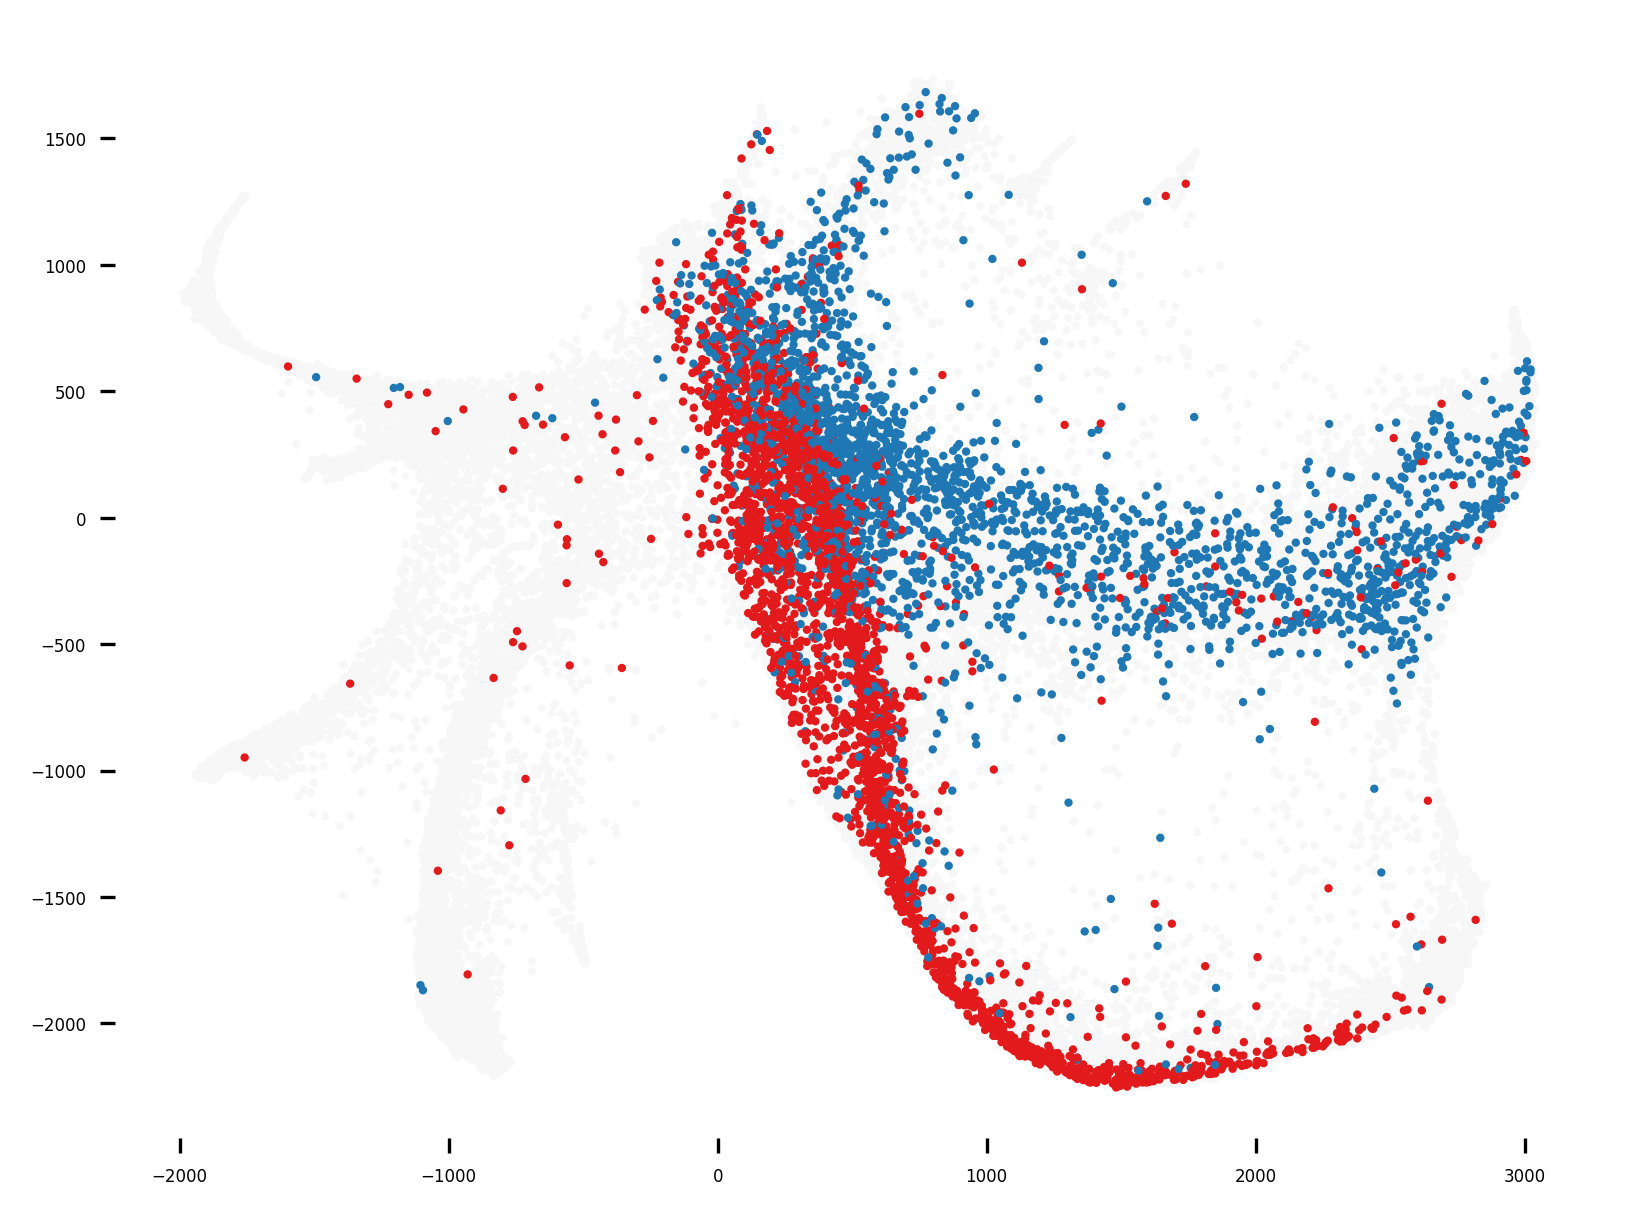

In [107]:
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import pickle
#labelforr=adata_for_r['reprogram_trajectory']
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 4
plt.rcParams['axes.linewidth'] = 0
plt.rcParams['font.family'] = "Arial"
# adata_orig.obsm["X_umap"] = adata_orig.obsm["X_emb"] 
# adata2=adata_orig[adata_orig.obs['time_info'].isin(['Day21','Day15'])]
# tmp = adata_orig[np.array((allindex3)),:]
# prediction = np.array(pre)
fig,ax=plt.subplots()
ax.scatter(adata.obsm["X_emb"][:,0],adata.obsm["X_emb"][:,1],c="#F7F7F7",s=1)
cmap = {0: '#1f78b4', 1: '#e31a1c'}
ax.scatter(adata2.obsm["X_emb"][:,0],adata2.obsm["X_emb"][:,1], s=1, c=list(map(lambda x:cmap[x], fatepre)))
# plt.show()

In [411]:
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from torch.autograd import Variable
import scanpy as sc
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

cudaid = 'cuda:6'
device2 = torch.device(cudaid)
geneEnc.to(device2)

Embeddings_path = '/home/zhengtuo/newdata1-cnn.pth.txt' # txt dir to save cell embeddings

all_embeddings = []
with torch.no_grad():
    for i in trange(adata.shape[0]):
        x = adata.X[i].toarray()
        geneExp = torch.tensor(x).to(device2)
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        all_embeddings.append(geneEmbedding)
    np.savez(Embeddings_path,all_embeddings)



100%|█████████████████████████████████████████████| 49116/49116 [00:17<00:00, 2870.14it/s]


In [412]:
mapembedding = []
with torch.no_grad():
    for i in trange(adata.shape[0]):
        x = adata.X[i].toarray()
        geneExp = torch.tensor(x).to(device2)
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        geneEmbedding=genemap(geneEmbedding)
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        mapembedding.append(geneEmbedding)


100%|█████████████████████████████████████████████| 49116/49116 [00:18<00:00, 2646.60it/s]


In [422]:
all_embeddings=np.array(all_embeddings)
all_embeddings.shape
mapembedding=np.array(mapembedding)
mapembedding.shape
adata.obsm['geneEnc']=all_embeddings
adata.obsm['genemap']=mapembedding


In [423]:
adata.obsm['X_pca']=adata.obsm['X_pca'].cpu().numpy()
adata.write('/home/zhengtuo/songtao/weinreb-test.h5ad')


In [487]:
adata=sc.read_h5ad('/home/zhengtuo/songtao/weinreb-test.h5ad')

In [434]:
import torch
import umap
n= np.load("/home/zhengtuo/newdata1-cnn.pth.txt.npz")
n=torch.tensor(n['arr_0'])
n=torch.reshape(n,(49116,256))
adata.obsm["X_pca"] = n
cs.pp.get_X_emb(adata, n_neighbors=20, umap_min_dist=1)


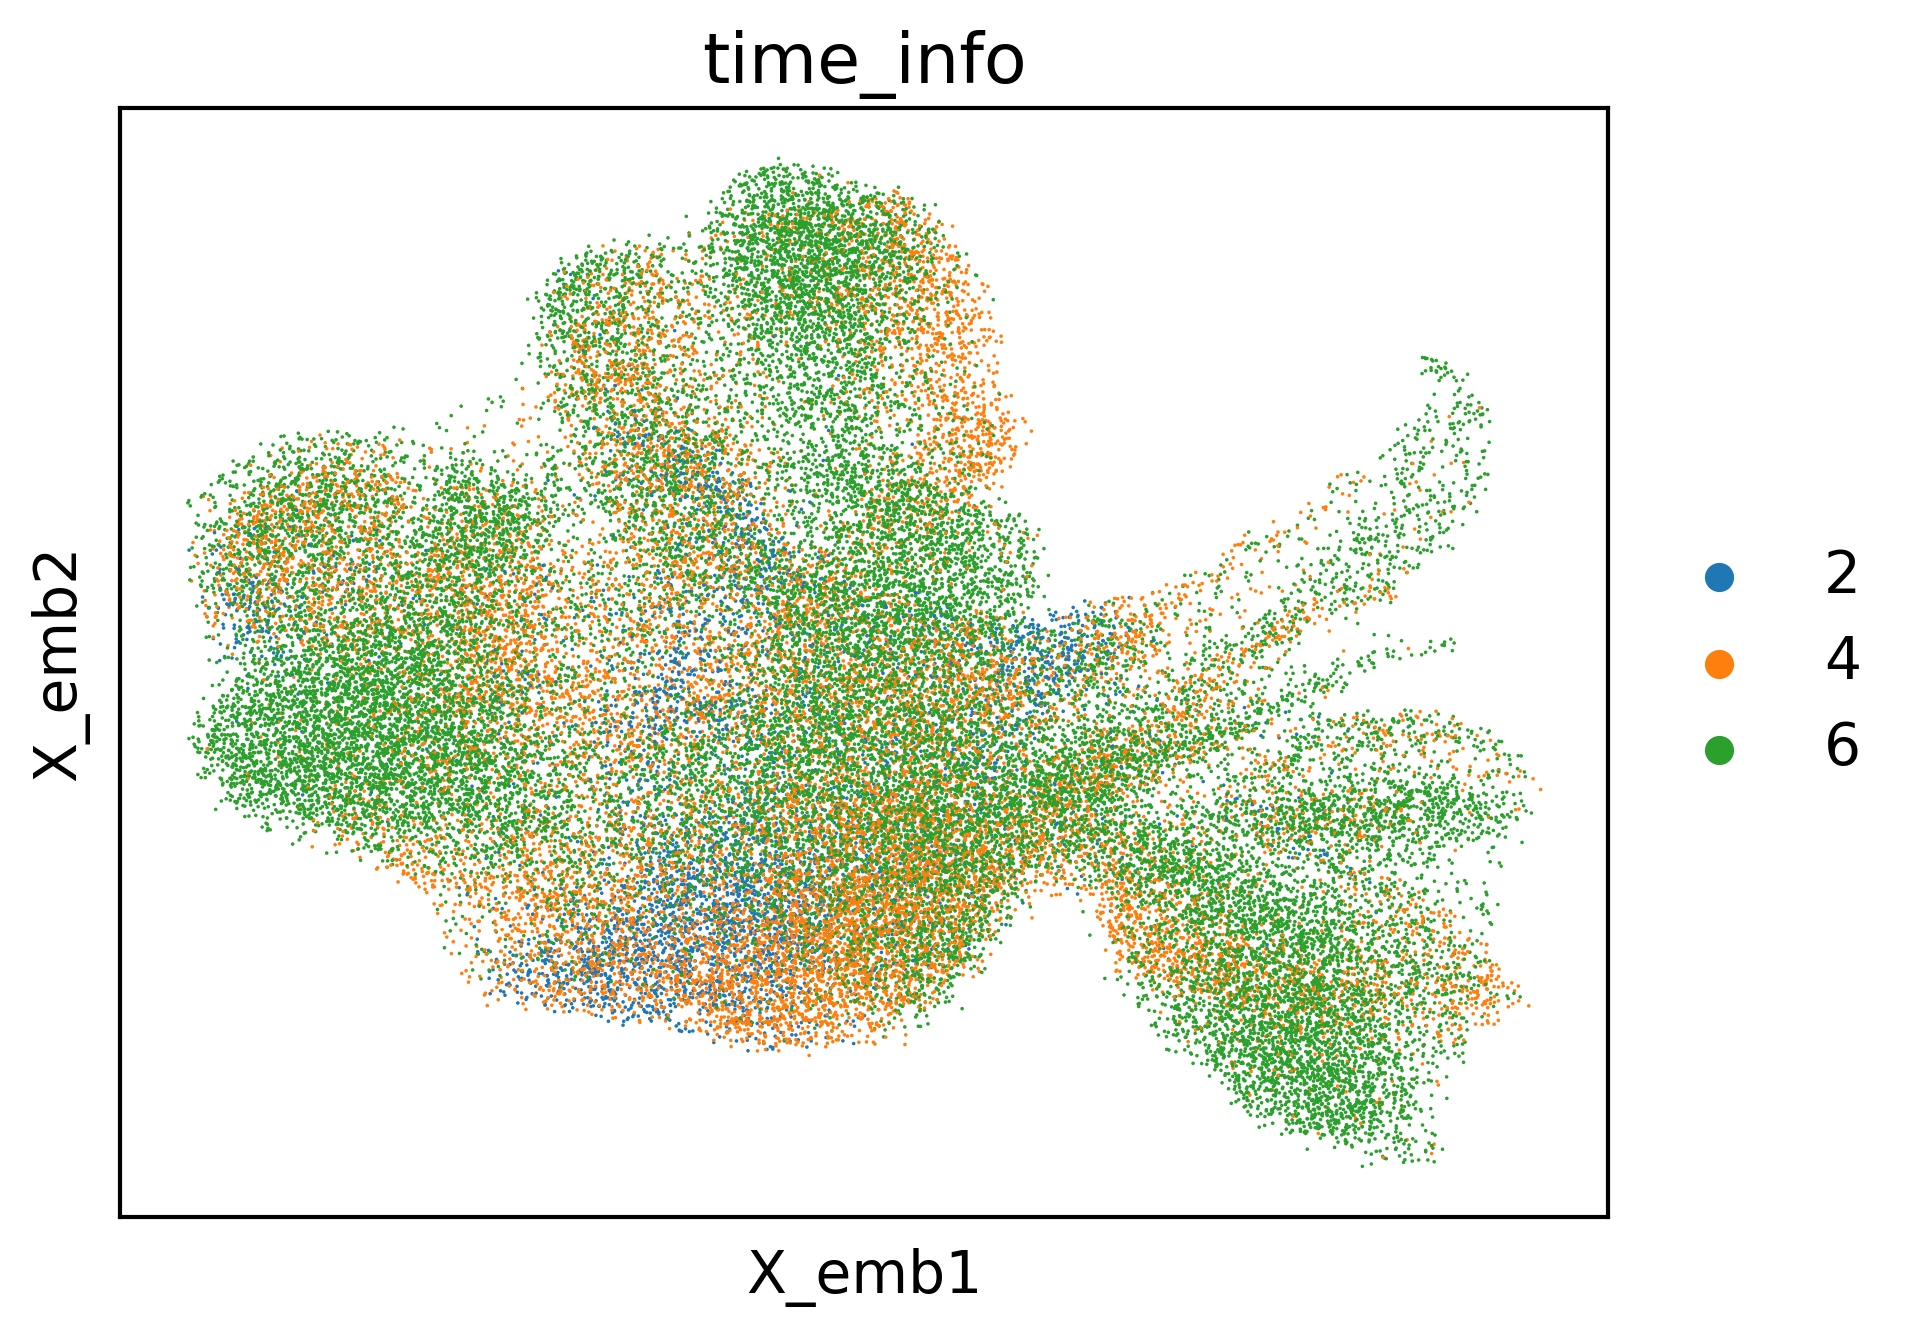

In [435]:
cs.pl.embedding(adata, color="time_info",s=3)

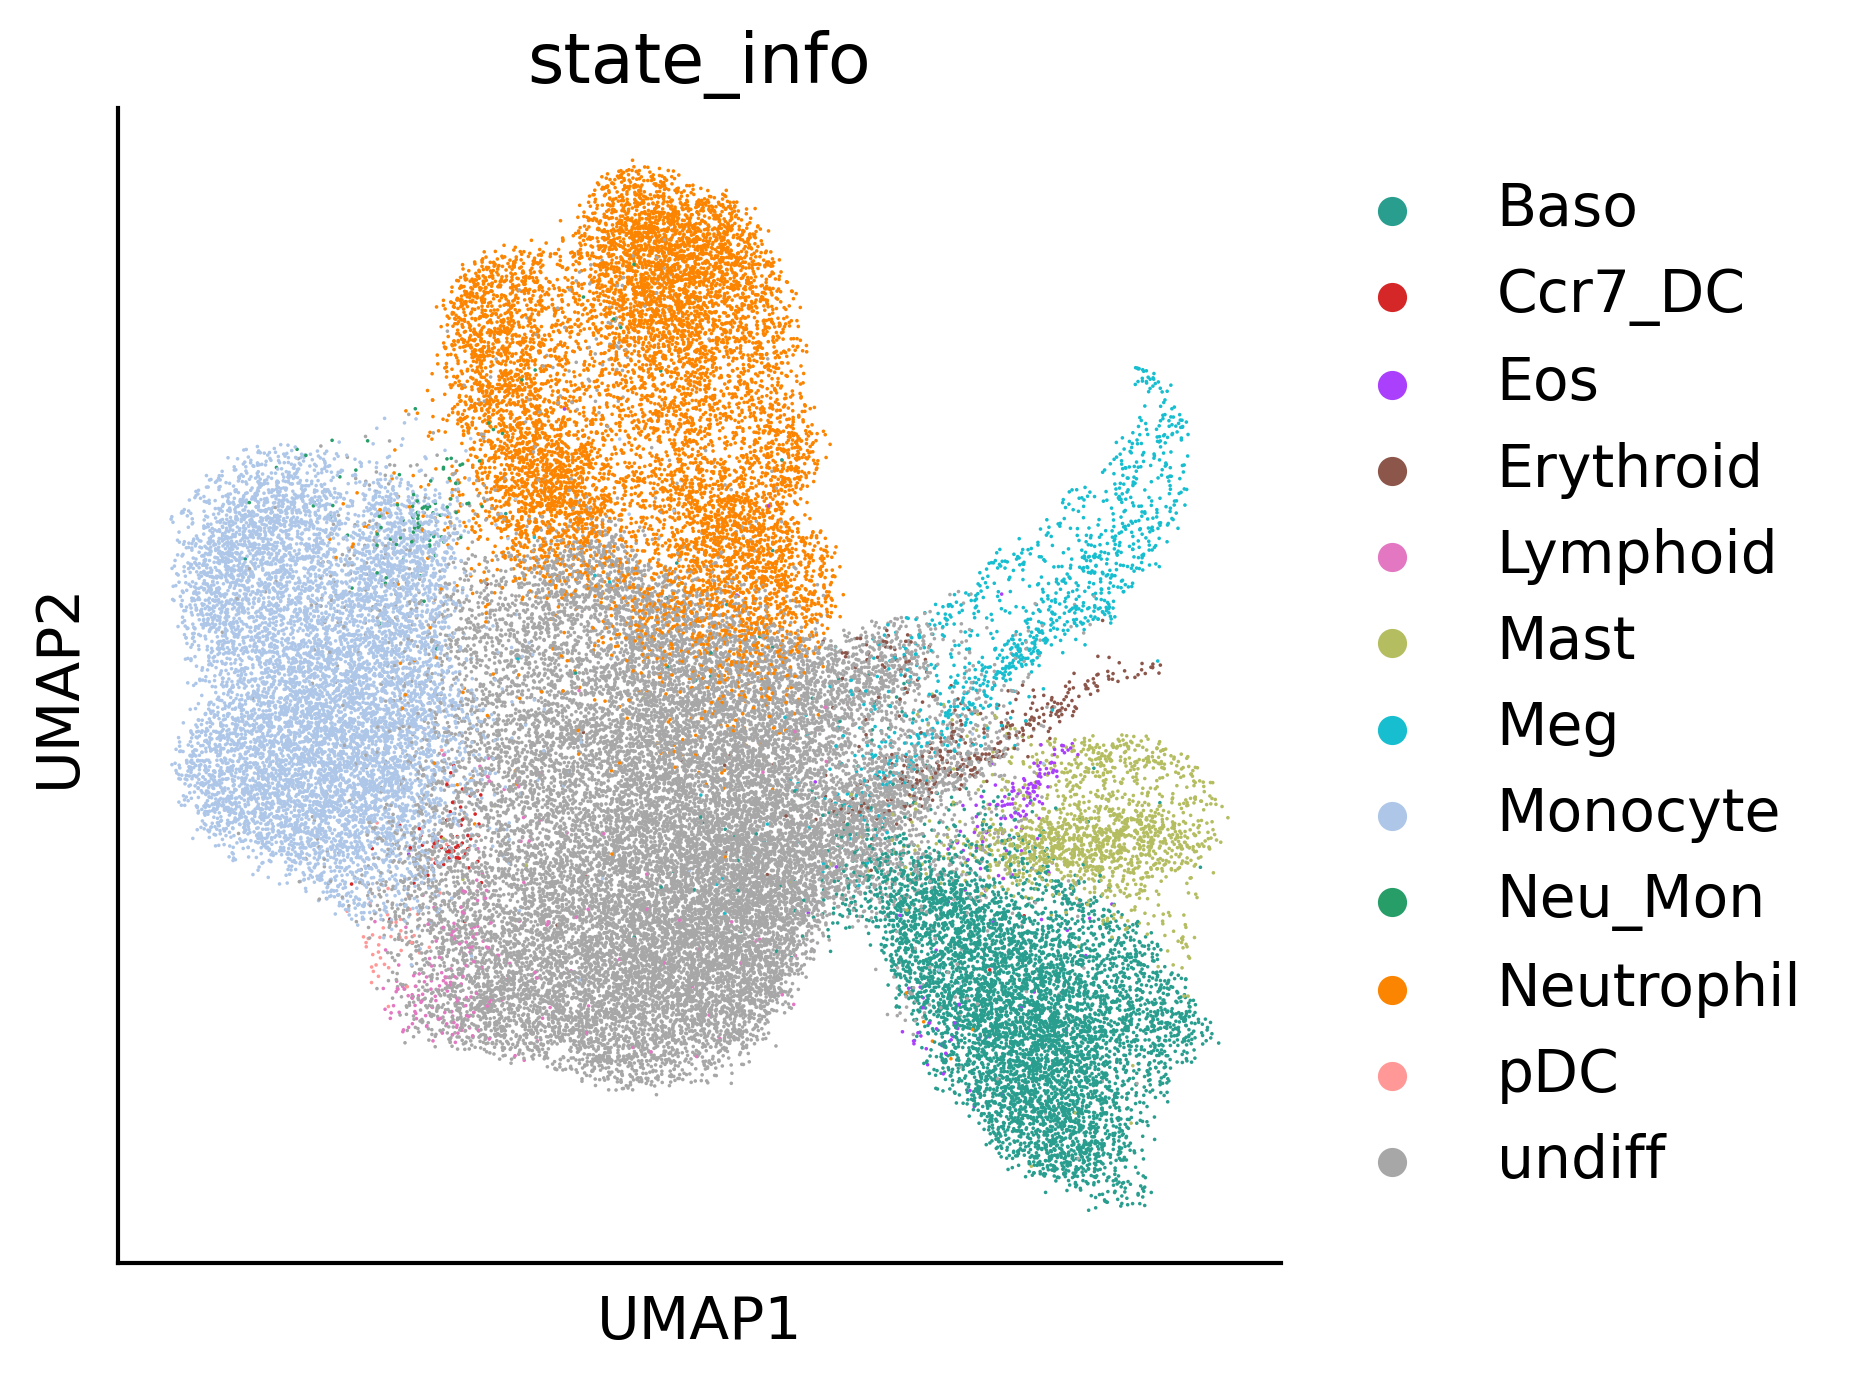

In [436]:
palette = dict(zip(sorted(np.unique(adata.obs['state_info'])), ['#299e8f', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#279e68', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2']))
palette['undiff'] = '#A7A7A7'
palette['Neutrophil'] = '#FB8401'
adata.uns['state_info_colors']=palette.values()
fig,ax=createFig()
fig.set_size_inches(5,5)
#cs.pp.get_X_emb(adata, n_neighbors=20, umap_min_dist=1)
#cs.pl.embedding(adata, color="state_info",s=3)
sc.pl.umap(adata, color="state_info",ax=ax,palette=palette, s=3)
#fig.savefig("/tmp/20221128_weinreb_original_embedding.pdf")


In [349]:
adata

AnnData object with n_obs × n_vars = 49116 × 25289
    obs: 'time_info', 'state_info', 'NeuMon_fate_bias', 'NeuMon_mask', 'progenitor_Ccr7_DC', 'progenitor_Mast', 'progenitor_Meg', 'progenitor_pDC', 'progenitor_Eos', 'progenitor_Lymphoid', 'progenitor_Erythroid', 'progenitor_Baso', 'progenitor_Neutrophil', 'progenitor_Monocyte', 'sp_500_idx', 'MLPClassifier_predicted_bias', 'growth_rate_raw', 'growth_rate_smooth'
    uns: 'available_map', 'clonal_time_points', 'data_des', 'progenitor_Monocyte_colors', 'state_info_colors', 'time_ordering', 'neighbors', 'umap', 'time_info_colors'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_umap', 'X_emb_old', 'geneEnc', 'genemap'
    obsp: 'distances', 'connectivities'

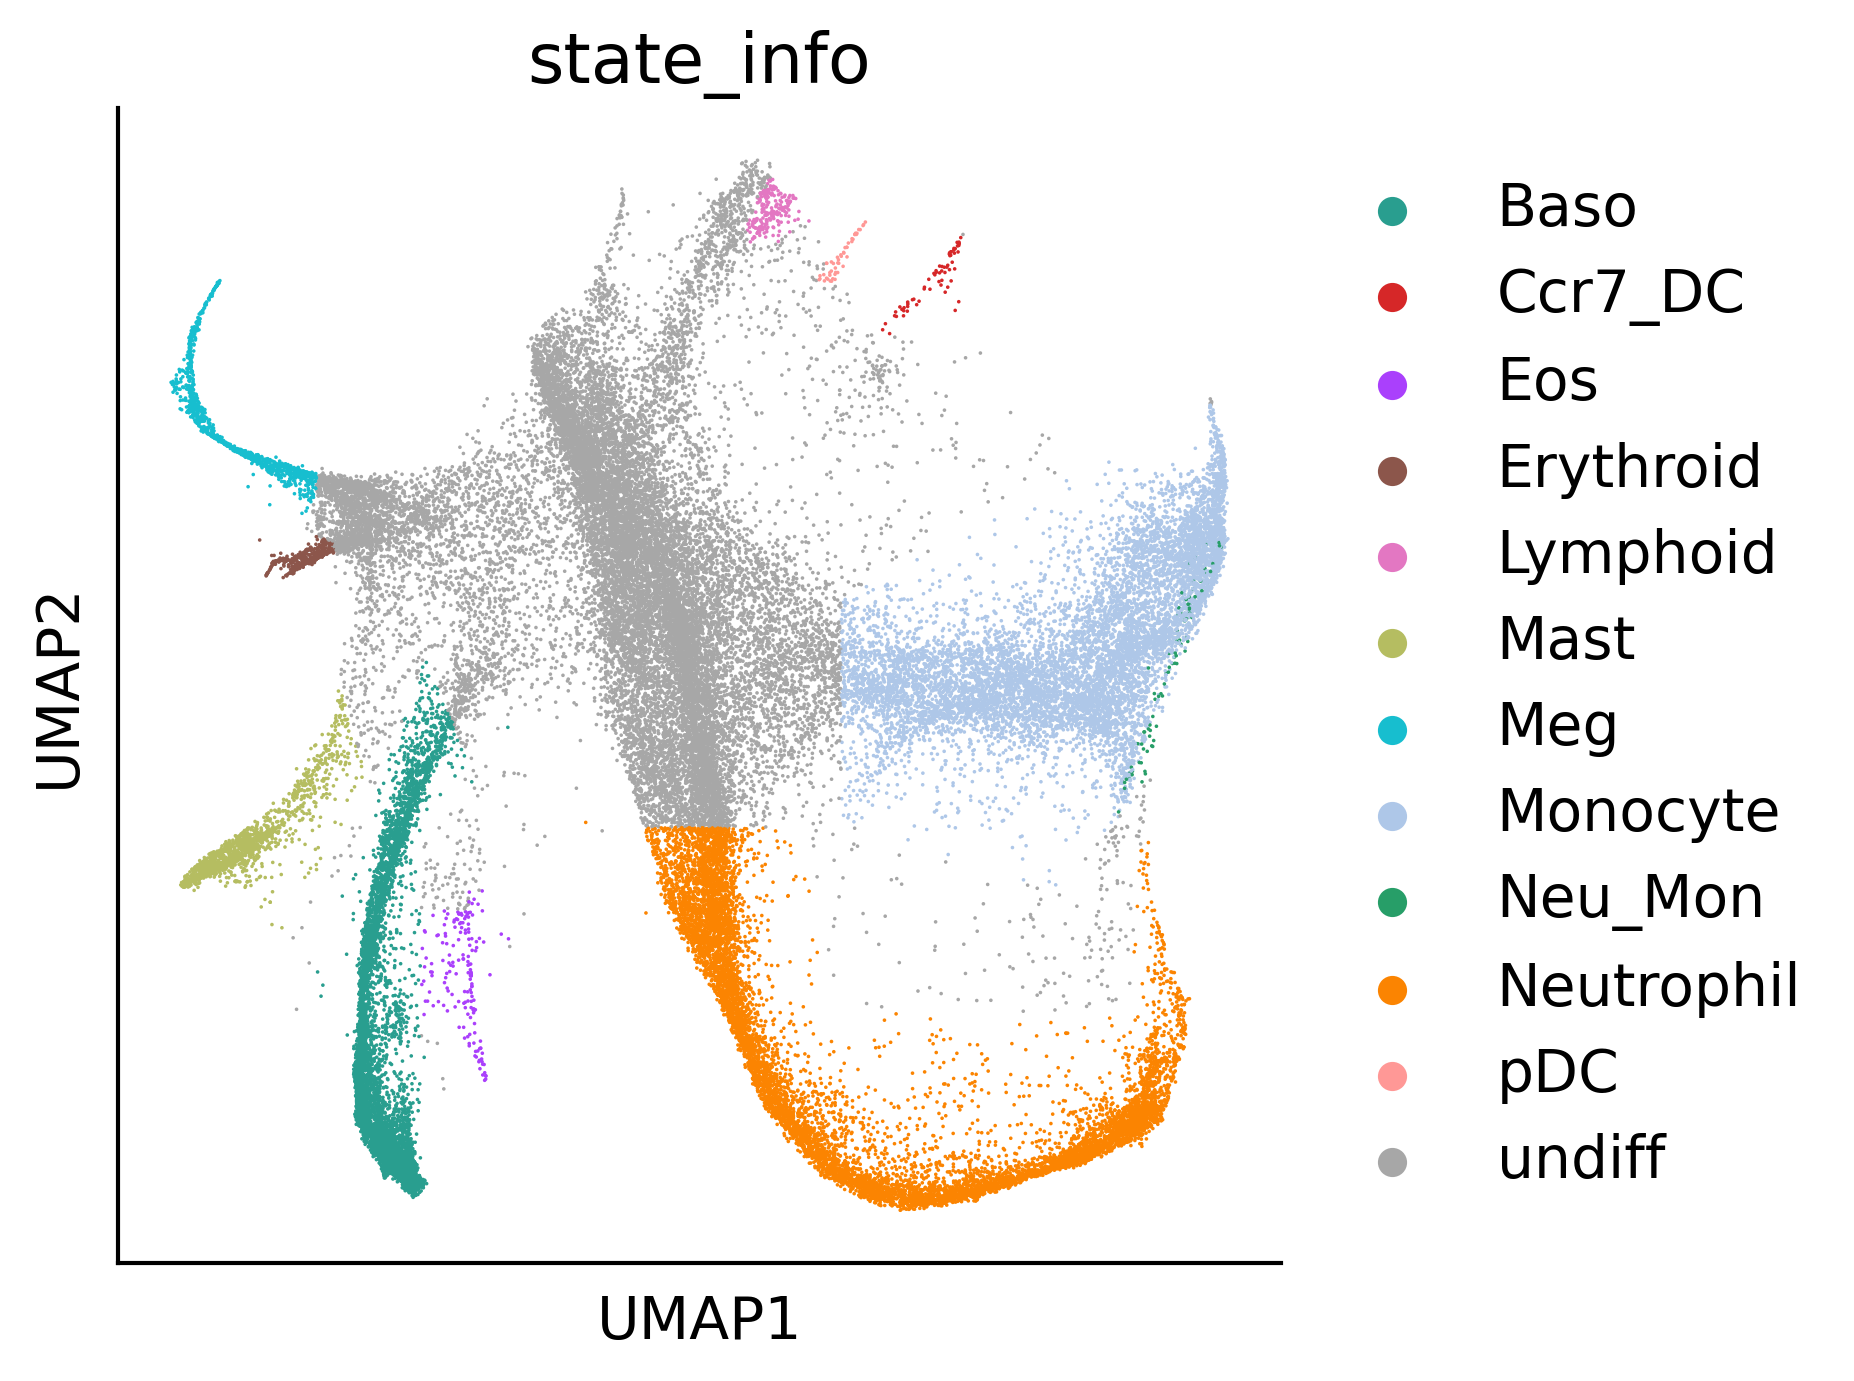

In [275]:
#原本的weinreb结果
adata = cs.datasets.hematopoiesis()
fig,ax=createFig()
fig.set_size_inches(5,5)
adata.obsm['X_umap']=adata.obsm['X_emb']
#cs.pp.get_X_emb(adata, n_neighbors=20, umap_min_dist=1)
sc.pl.umap(adata, color="state_info",ax=ax,palette=palette, s=3)

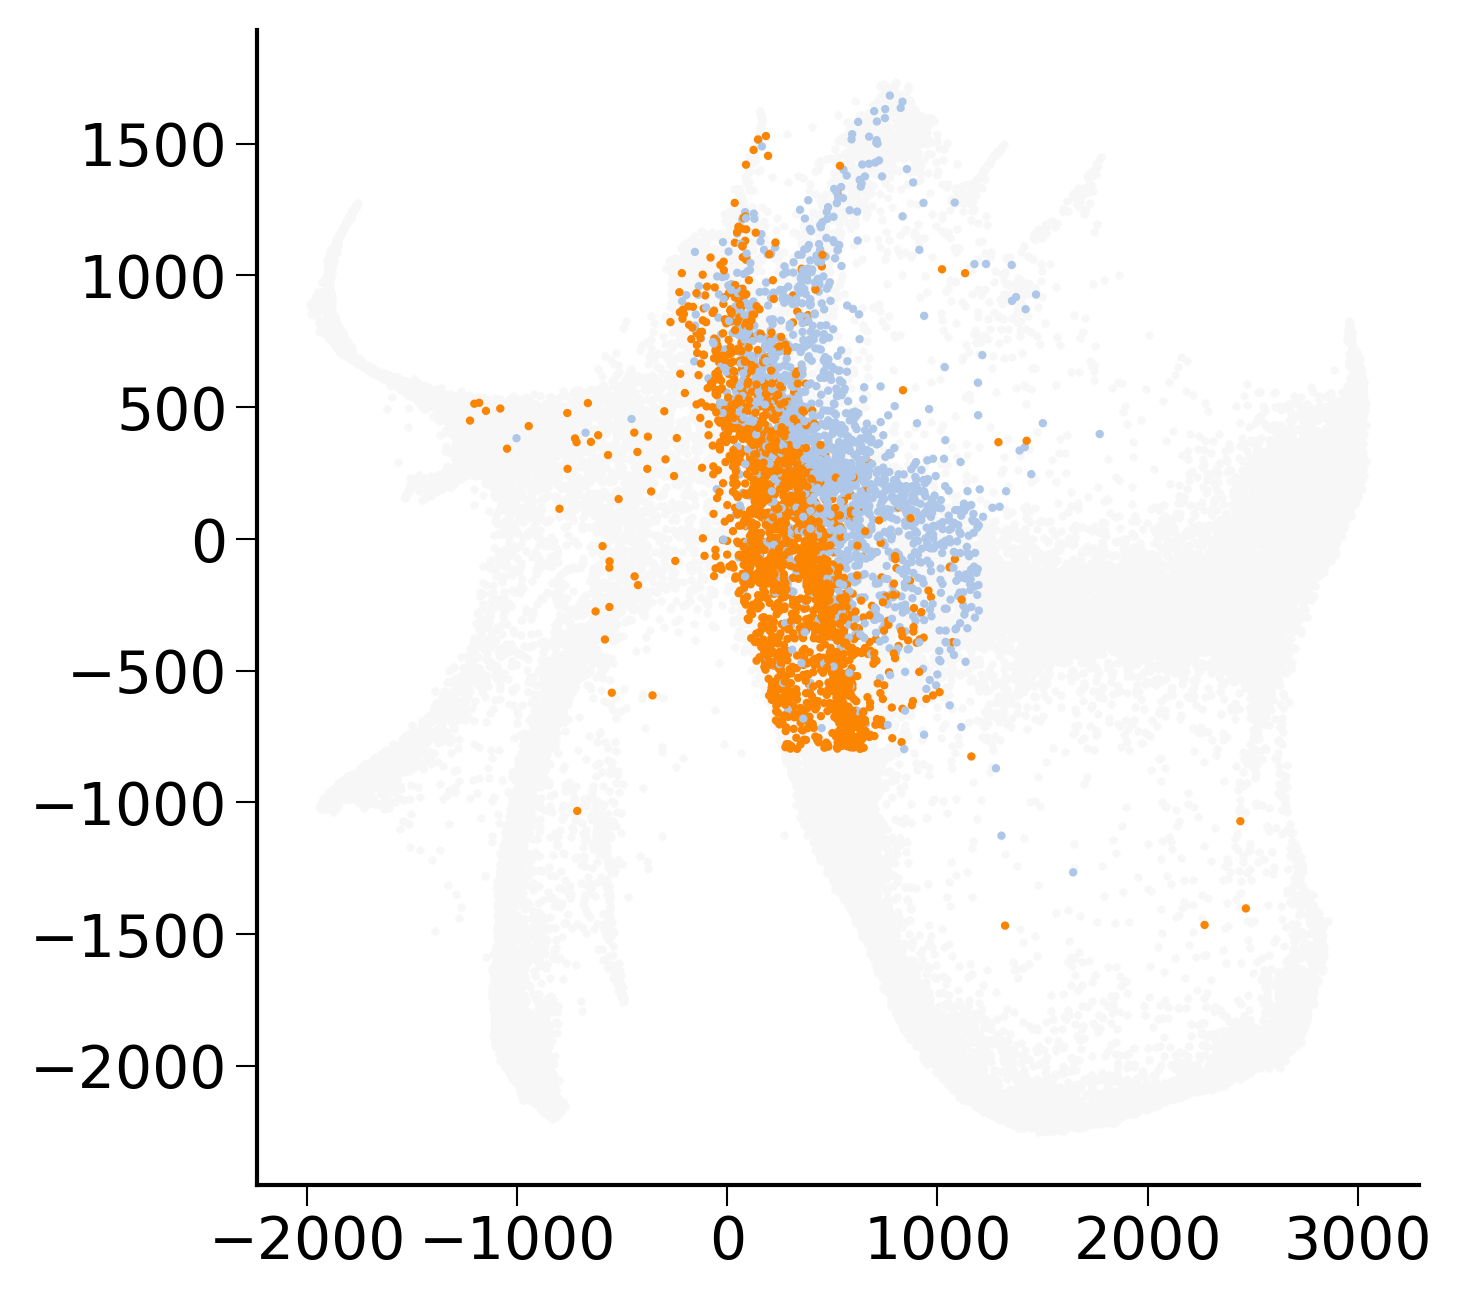

In [276]:
import scanpy as sc
import matplotlib.pyplot as plt
import torch
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['font.size'] = 4
# plt.rcParams['axes.linewidth'] = 0
# plt.rcParams['font.family'] = "Arial"

tmp = adata[np.array(list((allindex3))) ,:]
fig,ax=createFig()
fig.set_size_inches(5,5)
ax.scatter(adata.obsm["X_emb"][:,0],adata.obsm["X_emb"][:,1],c="#F7F7F7",s=1)
cmap={
 0: '#aec7e8',#Monocyte
 1: '#FB8401',#Neutrophil
}
ax.scatter(tmp.obsm["X_emb"][:,0],tmp.obsm["X_emb"][:,1], s=1, c=list(map(lambda x:cmap[int(x)], pre)))
plt.show()

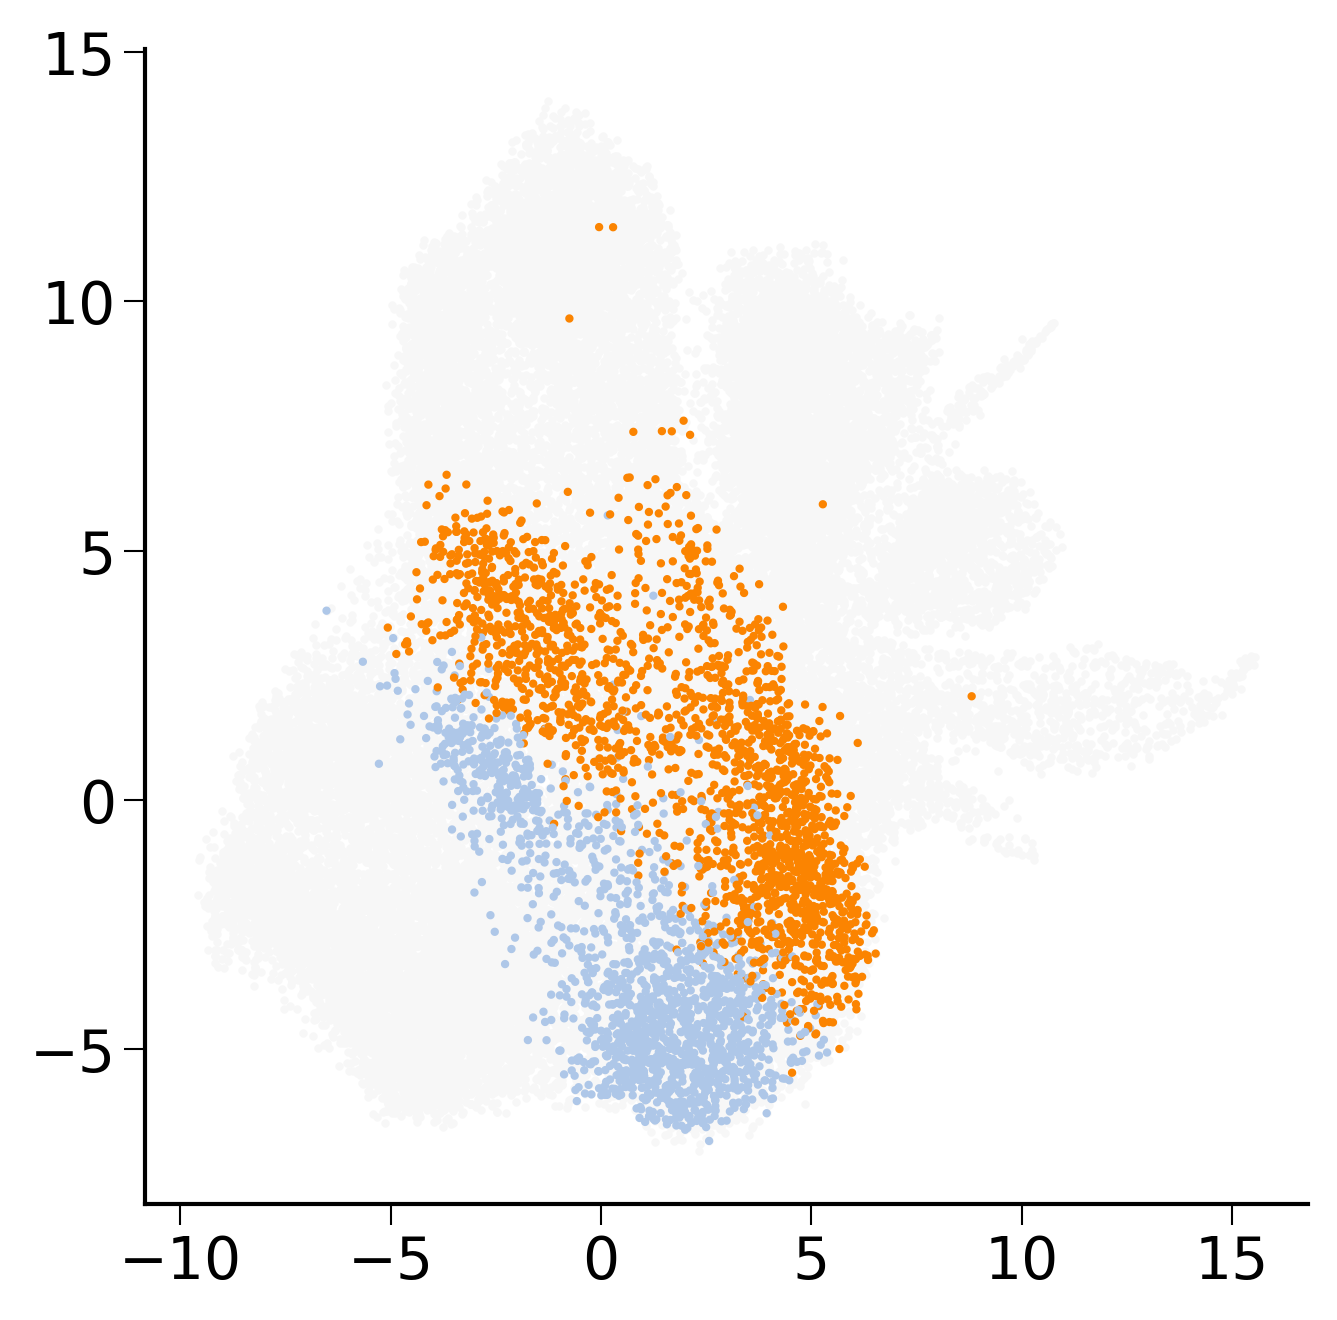

In [315]:

#adata.obsm["X_umap"] = adata.obs.loc[:,['SPRING-x', 'SPRING-y']].to_numpy()
tmp = adata[np.array(np.array((allindex3))) ,:]
#prediction = list(map(lambda x: celltype_category [x], pre_labels))
fig,ax=createFig()
fig.set_size_inches(5,5)
ax.scatter(adata.obsm["X_umap"][:,0],adata.obsm["X_umap"][:,1],c="#F7F7F7",s=1)
cmap={
 0: '#aec7e8',#Monocyte
 1: '#FB8401',#Neutrophil
}
ax.scatter(tmp.obsm["X_umap"][:,0],tmp.obsm["X_umap"][:,1], s=1, c=list(map(lambda x:cmap[int(x)], pre)))
plt.show()




In [316]:
from sklearn.metrics import silhouette_score
print(silhouette_score(tmp.obsm["X_emb"], pre))

0.27497992


In [460]:
def compute_velocity_on_grid(
    X_emb,
    M_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    autoscale=True,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + M_emb.sum(1))
    X_emb = X_emb[idx_valid]
    M_emb = M_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 0.5 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (M_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid ** 2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(M_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

        if autoscale:
            V_grid /= 3 * quiver_autoscale(X_grid, V_grid)

    return X_grid, V_grid

def quiver_autoscale(X_emb, V_emb):
    import matplotlib.pyplot as pl

    scale_factor = np.abs(X_emb).max()  # just so that it handles very large values
    fig, ax = pl.subplots()
    Q = ax.quiver(
        X_emb[:, 0] / scale_factor,
        X_emb[:, 1] / scale_factor,
        V_emb[:, 0],
        V_emb[:, 1],
        angles="xy",
        scale_units="xy",
        scale=None,
    )
    Q._init()
    fig.clf()
    pl.close(fig)
    return Q.scale / scale_factor

(39568, 1, 256)

100%|██████████████████████████████████████████████| 39568/39568 [00:40<00:00, 965.28it/s]
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/numpy/core/function_base.py:164: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  y[-1] = stop


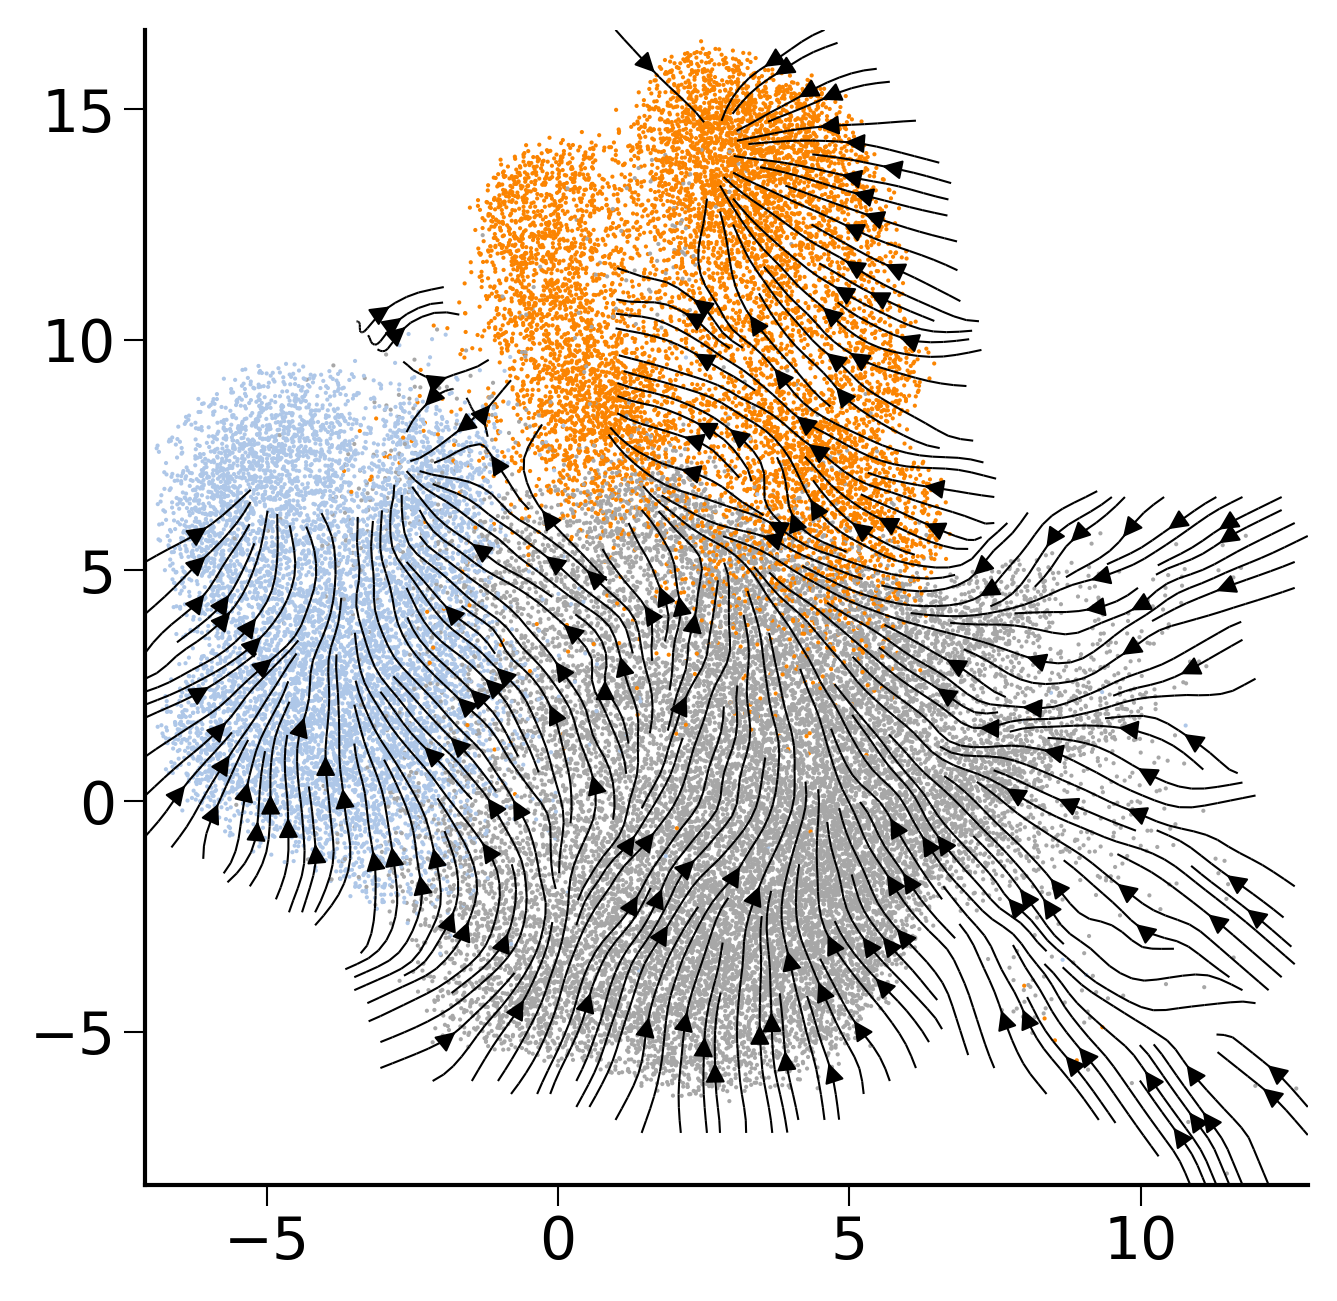

In [493]:
import numpy as np
from scipy.stats import norm as normal
from sklearn.neighbors import NearestNeighbors
from einops import repeat
from sklearn.metrics.pairwise import cosine_similarity
adata.obsm['geneEnc']=adata.obsm['geneEnc'].squeeze()
adata.obsm['genemap']=adata.obsm['genemap'].squeeze()
sc.pp.neighbors(adata, use_rep='geneEnc')

adata = adata[
    list(map(lambda x: x in ['undiff','Monocyte','Neutrophil'], adata.obs['state_info']))
]
X = adata.obsm['geneEnc']
M = adata.obsm['genemap']
N = adata.obsp['connectivities']
E = adata.obsm["X_umap"]
norm = lambda x: (x-min(x))/(max(x)-min(x))

dE = []
for i in tqdm.trange(N.shape[0]):
    indices = np.argwhere(np.array(N[i].toarray().flatten())).flatten()
    cosine_similarities = cosine_similarity(
        repeat(M[i], 'd -> n d', n = len(indices))-X[i], 
        X[indices]-X[i]
    )[0]
    # gk = norm(np.exp(-((E[indices,0] - E[i,0]) ** 2 + ((E[indices,1] - E[i,1]) ** 2)) / (2 * 0.5 ** 2)))
    # qt = np.quantile(cosine_similarities, 0.1)
    # cosine_similarities = np.array(list(map(lambda x: x if x > qt else 0, cosine_similarities)))
    cosine_similarities = norm(cosine_similarities)
    dE.append(((E[indices] - E[i]).T * cosine_similarities.T).mean(1))
dE = np.vstack(dE)
gE, gdE = compute_velocity_on_grid(E,dE,density=2, adjust_for_stream=True,smooth=True)
fig,ax=createFig()
fig.set_size_inches(5,5)
palette = sc.pl._tools.scatterplots._get_palette(adata, 'state_info')
ax.scatter(E[:,0],E[:,1],s=1, linewidths=0,c=list(map(lambda x: palette[x], adata.obs['state_info'])))
stream_kwargs = {
        "linewidth": 0.5,
        "density": 3,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}
ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)